# Basin orientation compared to fault strike

In [47]:
# first, import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import numpy.ma as ma

import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import swath_profile as swath

Define the base directory and some filenames. Read in the shapefile of points along the SAF

In [3]:
base_dir = '/home/bjdd72/san_andreas/'
data_dir = '/home/bjdd72/san_andreas/SAF_only/'
fname_prefix='SAF_only'
basin_shp = data_dir+fname_prefix+'_channel_slopes_by_basin_SO3.shp'
basin_gdf = gpd.read_file(basin_shp)
fault_pts = gpd.read_file(base_dir+'SanAndreasPoints.shp')

## Rose diagrams

Let's make some rose diagrams of the orientation of the fault strike and the orientation of the drainage basins

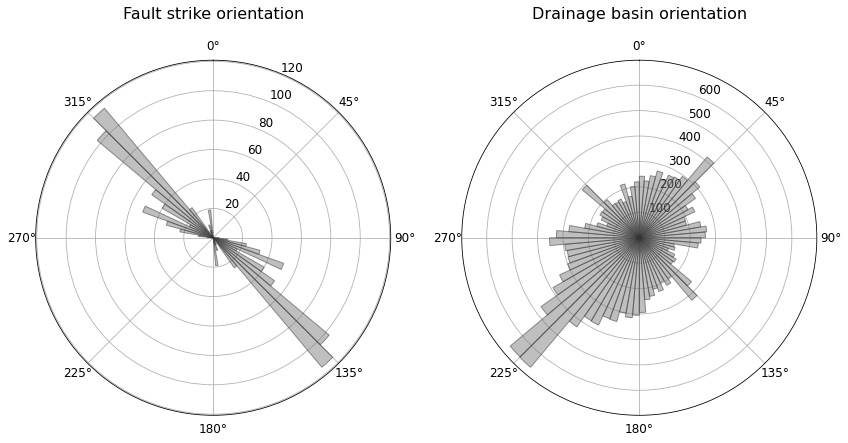

In [44]:
# bin the orientations into 10 degree bins.
bin_width = 5
bin_edges = np.arange(0, 360+bin_width, bin_width)
basins_hist, bin_edges = np.histogram(basin_gdf['azimuth'], bins=bin_edges)

# read in the fault azimuth shapefile
pts = gpd.read_file(data_dir+'SanAndreasPoints.shp')
# double the strikes with directions at 180 degrees to get a mirrored rose diagram
strikes = pts['azimuth'].values
strikes_mirrored = strikes + 180
all_strikes = np.concatenate([strikes, strikes_mirrored])
strike_hist, bin_edges = np.histogram(all_strikes, bins=bin_edges)

# set up the figure
fig = plt.figure(figsize=(14,8))

# set up the fault strike subplot
ax = fig.add_subplot(121, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Fault strike orientation', y=1.1, fontsize=16)
ax.bar(np.deg2rad(bin_edges[0:-1]), strike_hist, width=np.deg2rad(bin_width), align='edge', edgecolor='0.2', color='0.5', zorder=2, alpha=0.5)
ax.tick_params(labelsize=12)

# set up the basin orientation subplot
ax = fig.add_subplot(122, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Drainage basin orientation', y=1.1, fontsize=16)
ax.tick_params(labelsize=12)

# plot the histogram as bars. The bin edges are used as the left hand coordinate for the bars, minus the last edge. The histogram counts are the bar heights.
ax.bar(np.deg2rad(bin_edges[0:-1]), basins_hist, width=np.deg2rad(bin_width), align='edge', edgecolor='0.2', color='0.5', zorder=2, alpha=0.5)
#plt.subplots_adjust(wspace=0.5)
fig.savefig(data_dir+'SAF_rose_diagrams.png', dpi=300)

## Basin orientation along fault

Let's make another plot of the basin orientation compared to fault strike along the fault. We'll weight the basins by drainage area (larger weight to bigger basins), and colour the points by the median channel gradient.

0.00050088003625
0.000499599759


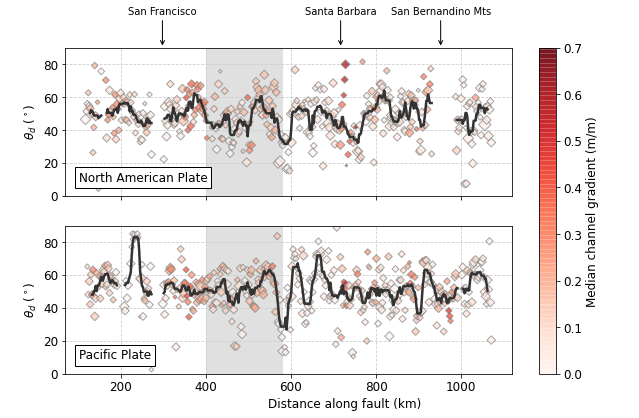

In [45]:
# now do the plotting along fault
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)
ax = ax.ravel()
# make a big subplot to allow sharing of axis labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# set the default colourmap
plt.rc('image', cmap='gray')

# plot the channel slope data
titles = ['North American Plate', 'Pacific Plate']
for i, title in enumerate(titles):
    # set up each subplot
    ax[i].grid(color='0.8', linestyle='--', which='both')
    ax[i].set_ylim(0,90)
    ax[i].text(0.03,0.1, titles[i], fontsize=12, transform=ax[i].transAxes, bbox=dict(facecolor='white'))
    ax[i].set_ylabel('$\\theta_d$ ($^\circ$)')

    # first, all the basins east of the fault (direction < 0)
    if i == 0:
        this_df = basin_gdf[basin_gdf['direction'] < 0]
    else:
    # then all the basins west of the fault (direction > 0)
        this_df = basin_gdf[basin_gdf['direction'] > 0]

    # group by the fault dist and get the mean deflection at each distance weighted by drainage area (larger areas = higher weights)
    g = this_df.groupby(['fault_dist'])
    gr = g.apply(lambda x: pd.Series(np.average(x['deflection'], weights=x['basin_area'])).reset_index(name='Deflection_weighted')).reset_index()
    area = this_df.groupby(['fault_dist'])['basin_area'].median()
    slope = this_df.groupby(['fault_dist'])['slope_medi'].median()
    
    # plot the deflection along fault and colour by median channel slope in each basin
    print(slope.min())
    norm = colors.Normalize(vmin=0, vmax=0.7)
    pcm = ax[i].scatter(x=gr['fault_dist'], y=gr['Deflection_weighted'], c=slope, cmap=cm.Reds, norm=norm, edgecolor='0.5', zorder=2, s=area/1000, marker='D', alpha=0.7)
    ax[i].axvspan(400, 580, facecolor='0.8', alpha=0.6, zorder=1)


    # rolling median
    slopes_df = gr.sort_values(by='fault_dist')
    slopes_df['rollmedian'] = slopes_df['Deflection_weighted'].rolling(10, center=True).median()
    #print(slopes_df)

    # create a mask for gaps in the median slopes
    these_dists = slopes_df['fault_dist'].values
    mask_starts = np.where(these_dists-np.roll(these_dists,1) > 10)[0]
    #print(mask_starts)
    mc = ma.array(slopes_df['rollmedian'].values)
    mc[mask_starts] = ma.masked
    ax[i].plot(slopes_df['fault_dist'], mc, c='0.2', zorder=100, lw=2.5, ls='-', alpha=1)

# placenames
labels_df = pd.read_csv(base_dir+'Uplift_rates/placenames.csv')
labels = labels_df['Label']
labels_dist = labels_df['fault_dist']
for i in range(0, len(labels)):
    ax[0].annotate(labels[i], xy=(labels_dist[i],90), xytext=(labels_dist[i], 110), ha='center', fontsize=10, arrowprops=dict(facecolor='k', arrowstyle="->"))

# finalise the figure
plt.xlabel('Distance along fault (km)')
fig.colorbar(pcm, ax=ax, label='Median channel gradient (m/m)')
plt.show()

In [41]:
# Save the figure
fig.savefig(data_dir+fname_prefix+'_basins_deflection.png', dpi=300, facecolor='white')
plt.clf()

<Figure size 432x288 with 0 Axes>

## Boxplots

Maybe boxplots of the angle along strike (or violin plots...) will say something more useful

In [74]:
# create some bins. Let's try analysing this every 50 km along fault
bin_width = 10
bin_array = np.arange(0, basin_gdf['fault_dist'].max()+bin_width, bin_width)

0         110.0
1         110.0
2         110.0
3         110.0
4         110.0
          ...  
18894    1070.0
18895    1070.0
18896    1070.0
18900    1070.0
18903    1070.0
Name: fault_dist, Length: 9330, dtype: category
Categories (108, float64): [0.0 < 10.0 < 20.0 < 30.0 ... 1040.0 < 1050.0 < 1060.0 < 1070.0]
         basin_area     azimuth  deflection   latitude   longitude  \
0      53309.000000    7.964627   50.894860  39.021498 -123.698779   
1      18131.000000  304.337516   21.060099  39.019370 -123.709397   
2      69954.000000  346.132682   23.177698  39.019973 -123.703650   
3      76149.000000  314.561815   11.609073  39.019973 -123.703627   
4      20501.000000   87.725781   50.831639  39.016151 -123.694868   
...             ...         ...         ...        ...         ...   
18894  37573.773146  176.547019   49.647930  33.560124 -115.964304   
18895  26538.510902  155.727947   25.191920  33.560098 -115.966556   
18896  47075.708015  164.879401   35.781278  33.560097

/home/bjdd72/miniconda3/envs/fault-swath/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


58        120.0
64        120.0
65        120.0
66        120.0
69        120.0
          ...  
18902    1060.0
18904    1070.0
18905    1070.0
18906    1070.0
18907    1070.0
Name: fault_dist, Length: 9578, dtype: category
Categories (108, float64): [0.0 < 10.0 < 20.0 < 30.0 ... 1040.0 < 1050.0 < 1060.0 < 1070.0]
         basin_area     azimuth  deflection   latitude   longitude  \
58     36854.000000  269.347896   47.289141  38.979924 -123.684401   
64     11028.000000  223.860520   85.950237  38.976801 -123.682246   
65         1.000000   97.833737   40.652252  38.976792 -123.682223   
66     13273.000000  239.377159   71.616395  38.976792 -123.682223   
69     46280.000000  219.730412   89.917872  38.974231 -123.677870   
...             ...         ...         ...        ...         ...   
18902  39249.740884  149.393799   18.163370  33.556834 -115.974318   
18904  57709.183178  156.197708   25.725476  33.556374 -115.967839   
18905  23006.307740  143.018528   11.224846  33.556366

/home/bjdd72/miniconda3/envs/fault-swath/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


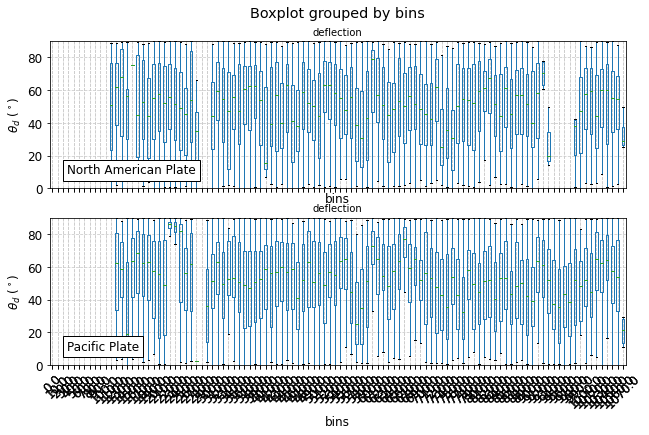

In [89]:
# now do the plotting along fault
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)
ax = ax.ravel()
# make a big subplot to allow sharing of axis labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# set the default colourmap
plt.rc('image', cmap='gray')

# plot the channel slope data
titles = ['North American Plate', 'Pacific Plate']
for i, title in enumerate(titles):
    # set up each subplot
    ax[i].grid(color='0.8', linestyle='--', which='both')
    ax[i].set_ylim(0,90)
    ax[i].text(0.03,0.1, titles[i], fontsize=12, transform=ax[i].transAxes, bbox=dict(facecolor='white'))
    ax[i].set_ylabel('$\\theta_d$ ($^\circ$)')

    # first, all the basins east of the fault (direction < 0)
    if i == 0:
        this_df = basin_gdf[basin_gdf['direction'] < 0]
    else:
    # then all the basins west of the fault (direction > 0)
        this_df = basin_gdf[basin_gdf['direction'] > 0]
        
    # group by the bins and get the mean deflection at each distance weighted by drainage area (larger areas = higher weights)
    bins = pd.cut(this_df['fault_dist'], bin_array, labels = bin_array[:-1])
    print(bins)
    this_df['bins'] = bins
    print(this_df)
    bp = this_df.boxplot(column='deflection',by='bins', ax=ax[i], rot=45, sym="", labels=None)
    #labels = np.arange(0, bin_array.max(), 100)
    #ax[i].set_xticklabels(labels, ha='right')
    